<a href="https://colab.research.google.com/github/michaelherediaperez/EspecializacionEstructuras/blob/main/01_DinamicaEstructural/Dinamica_Trabajo02_MHP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trabajo 2/3: Sólución de la respuesta dinámica en edificaciones en 2D.

Dinámica de Estructuras 

Universidad Nacional de Colombia Sede Manizales

Hecho por: Michael Heredia Pérez (mherediap@unal.edu.co)

Fecha: Septiembre 19 / 2021


In [ ]:
# Librerías necesarias
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import sympy as sp

Se crean las siguiintes funciones para agilizar el desarrollo del código y facilitar su entendimiento

In [ ]:
def Calcula_Sa(T_a):
    "Función para calular el valor de la aceleración aproximada Sa."
    global Aa, Av, Fa, Fv, I, T_C, T_L
    if T_a < T_C:
        return 2.5*Aa*Fa*I
    elif T_a > T_L:
        return 1.2*Av*Fv*T_L*I/T_a**2
    else:
        return 1.2*Av*Fv*I/T_a

def Calcula_k(T_a):
    "Función para calcular el exponente k."
    if T_a <= 0.5:
        return 1
    elif T_a > 2.5:
        return 2
    else:
        return 0.75+0.5*T_a

def is_pos_def(A):
    M = np.matrix(A)
    return np.all(np.linalg.eigvals(M+M.transpose()) > 0)

def SubmatricesDeK(K):
    """Función para obtener las submatrices del problema de la condensación 
    matricial: k0, k1, k2, 3. Basada en el libro 'Dinamica estructural aplicada 
    al diseño sísmico' del profesor Luis Garcia Reyes (1998), cap 8."""

    # Ajuste vertical de la sub matriz
    Ks = np.array([K[0]+K[1]+K[2],
                   K[3]+K[4]+K[5],
                   K[6]+K[7]+K[8]])
    
    # Condensación horizontal.
    Ks = np.array([Ks[:, 0] + Ks[:, 1] + Ks[:, 2],
                   Ks[:, 3] + Ks[:, 4] + Ks[:, 5],
                   Ks[:, 6] + Ks[:, 7] + Ks[:, 8]]).T
    return Ks

Algunas constantes para facilidad de lectura del código y llamados de vectores.


In [ ]:
b, h     = 0, 1         #           base y altura de una sección.
NL1, NL2 = 0, 1         #           Nodo local 1, nodo local 2.
X, Y, T  = 0, 1, 2      #           Dirección x, dirección y, giro.
g        = 9.81         # [m/s^2]   Valor de la gravedad .   

A partir del enunciado se extraen los siguientes datos:

In [ ]:
N = 10  # Factor asignado para trabajo individual.

In [ ]:
# Configuración de carga.
D_LOSA  = (200 + 20*N)/1000     # [tnf/m^2]   Peso muerto de la losa.
D_CUB   = D_LOSA / 2            # [tnf/m^2]   Peso muerto de la cubierta.

# Geometría de la edificación.
H_EP   = 3.40                   # [m  ]  Altura de entre piso.
NPISOS = 3                      # [   ]  Número de pisos
LL     = np.array([5, 5.50, 7]) # [m  ]  Luces en el pórtico.
L_MAY  = max(LL)                # [m  ]  Luz mayor.   
A_LOSA = (7+7+7)*(5.5+5)        # [m^2]  Área de la losa.

# Propiedades elásticas del material.
fpc = 210                       # [kgf/cm^2]  Esfuerzo del concreto (21 MPa).
E   = 15100*np.sqrt(fpc)*10     # [tnf/m^2 ]  Módulo de elasticidad concreto.

DELTA_MAX = 3.4                 # [cm]  Desplazamiento relativo máximo.

In [ ]:
print(">>> Cálculo de la altura de la viga mínimo según NSR-10:\n")
print(">>> hv mínimo = ", round(L_MAY/21, 2), "m")

>>> Cálculo de la altura de la viga mínimo según NSR-10:

>>> hv mínimo =  0.33 m


In [ ]:
# Propiedades geométricas de COLUMNAS.
DIM_COL = np.array([0.40, 0.40])          # [m  ]  b, h.
A_COL   = np.prod(DIM_COL)                # [m^2]  Área sección trans. 
I_COL   = DIM_COL[b]*(DIM_COL[h]**3)/12   # [m^4]  Inercia. 

# Propiedades geométricas de VIGAS, por Tabla C.9.5(a) hmin = K/18.5 = 0.3m.
DIM_VIG = np.array([0.30, 0.40])          # [m  ]  b, h. Tabla C.9.5(a).  
A_VIG   = np.prod(DIM_VIG)                # [m^2]  Área sección trans. 
I_VIG   = DIM_VIG[b]*(DIM_VIG[h]**3)/12   # [m^4]  Inercia.

# Vector de áreas, inercias e inclinaciones: 9 columnas y 6 vigas.
aa     = np.concatenate((np.tile(A_COL, 9), np.tile(A_VIG, 6)))
ii     = np.concatenate((np.tile(I_COL, 9), np.tile(I_VIG, 6)))
# Columnas inclinadas a 90° y vigas a 0°
ttheta = np.concatenate((np.tile(np.pi/2, 9), np.tile(0, 6)))

In [ ]:
print(">>> Cargas de la edificación:\n")
print(">>> Peso muerto de losa:    D_losa = ", D_LOSA, "tnf/m^2.")
print(">>> Peso muerto de cbierta: D_cub  = ", D_CUB, "tnf/m^2.")

print("\n>>> Dimensiones de la columna:\n")
print(">>> Base de la sección trasnversal:    bc = ", DIM_COL[b], "m.")
print(">>> Altura de la sección trasnversal:  hc = ", DIM_COL[h], "m.")
print(">>> Área de la sección trasnversal:    Ac = ", A_COL.round(2), "m^2.")
print(">>> Inercia de la sección trasnversal: Ic = ", round(I_COL,6), "m^4.")

print("\n>>> Dimensiones de la viga:\n")
print(">>> Base de la sección trasnversal:    bv = ", DIM_VIG[b], "m.")
print(">>> Altura de la sección trasnversal:  hv = ", DIM_VIG[h], "m.")
print(">>> Área de la sección trasnversal:    Av = ", A_VIG.round(2), "m^2.")
print(">>> Inercia de la sección trasnversal: Ic = ", round(I_VIG,7), "m^4.")

>>> Cargas de la edificación:

>>> Peso muerto de losa:    D_losa =  0.4 tnf/m^2.
>>> Peso muerto de cbierta: D_cub  =  0.2 tnf/m^2.

>>> Dimensiones de la columna:

>>> Base de la sección trasnversal:    bc =  0.4 m.
>>> Altura de la sección trasnversal:  hc =  0.4 m.
>>> Área de la sección trasnversal:    Ac =  0.16 m^2.
>>> Inercia de la sección trasnversal: Ic =  0.002133 m^4.

>>> Dimensiones de la viga:

>>> Base de la sección trasnversal:    bv =  0.3 m.
>>> Altura de la sección trasnversal:  hv =  0.4 m.
>>> Área de la sección trasnversal:    Av =  0.12 m^2.
>>> Inercia de la sección trasnversal: Ic =  0.0016 m^4.


A parti del Título A de la NSR-10, capítulo 2, se toman los siguientes valores para la ubicación y tipo de suelo de la edificación. 

In [ ]:
# Considerando que Ciudad = Manizales, Grupo de uso = II, Suelo = D.
Av = 0.25                     # A.2.3-2.
Aa = 0.25                     # A.2.3-2.
Fa = 1.3                      # A.2.4-3.
Fv = 1.9                      # A.2.4-4.
I  = 1.10                     # A.2.5-1.

# Parámetros dinámicos para una estructura con pórticos de concreto. 
Ct    = 0.047                 # A.2.5-1.  
alfa  = 0.90                  # A.2.5-1.

## Espectro de diseño.

Con base en el título A de la NSR-10, capítulo 2, se procede a calcular el espectro de aceleraciones aproximado para la edificación.

In [ ]:
# Periodos.
T_a = Ct*(H_EP*NPISOS)**alfa       # Periodo fundamental aproximado, A.4.2-3.
T_0 = 0.1*(Av*Fv)/(Aa*Fa)   # Periodo inicial.
T_C = 0.48*(Av*Fv)/(Aa*Fa)  # Periodo corto.
T_L = 2.4*Fv                # Periodo largo.        Figura A.2.6-1.

# Aceleración para el periodo fundamental aproximado.
Sa = Calcula_Sa(T_a) 
# Valor del exponente k (minúscula)
k = Calcula_k(T_a) 

In [ ]:
print(">>> Periodos calculados según Cap A.2 NSR-10: \n")
print(">>> Periodo aproximado: Ta = ", round(T_a, 2), "s.")
print(">>> Periodo inicial:    T0 = ", round(T_0, 2), "s.")
print(">>> Periodo corto:      Tc = ", round(T_C, 2), "s.")
print(">>> Periodo largo:      Tl = ", round(T_L, 2), "s.")
print("\n>>> Aceleración aproximada: Sa = ", round(Sa, 2), "g.")
print(">>> Exponente k:            k  = ", round(k, 2))

>>> Periodos calculados según Cap A.2 NSR-10: 

>>> Periodo aproximado: Ta =  0.38 s.
>>> Periodo inicial:    T0 =  0.15 s.
>>> Periodo corto:      Tc =  0.7 s.
>>> Periodo largo:      Tl =  4.56 s.

>>> Aceleración aproximada: Sa =  0.89 g.
>>> Exponente k:            k  =  1


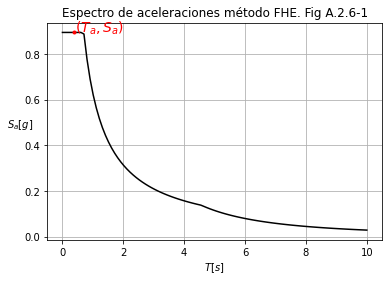

In [ ]:
# Gráfica del espectro de aceleraciones 
tt_espectro = np.linspace(0, 10, 100)
ssa_espectro = []
for t in tt_espectro:
    sa_t = Calcula_Sa(t)
    ssa_espectro.append(sa_t)

plt.figure()
plt.plot(tt_espectro, ssa_espectro, '-k')
plt.plot(T_a, Sa, '.r', linewidth=15)
plt.title('Espectro de aceleraciones método FHE. Fig A.2.6-1')
plt.xlabel(r'$T[s]$')
plt.ylabel(r'$S_a[g]$', rotation=0)
plt.text(1.1*T_a, Sa, r"$(T_a,S_a)$", fontsize=14, color='r')
plt.grid()
plt.show()

## Cálculo de fuerzas horizontales, método FHE

Con base en el subcapítulo A.4.3 de la NSR-10, se calculan las fuerzas horizontales por el método de la Fuerza Horizontal Equivalente - FHE.

In [ ]:
M_TOTAL = (2*D_LOSA+D_CUB)*A_LOSA                   # [tnf] Masa total.
mm_piso = np.array([D_LOSA, D_LOSA, D_CUB])*A_LOSA  # [tnf] Masa x piso.
hh_piso = np.array([H_EP, 2*H_EP, 3*H_EP])          # [m]   Altura a cada piso.                

Vs = M_TOTAL*Sa   # Cortante de base [tnf].     

mm_hh_k   = mm_piso*hh_piso**k              
S_mm_hh_k = np.sum(mm_hh_k)
C_vx      = mm_hh_k / S_mm_hh_k

# Vector de fuerzas horizontales equivalentes [kgf].
ffhhee = C_vx*Vs              

In [ ]:
print(">>> Datos de la FHE:\n")
print(">>> Cortante basal o de base: Vs = ", round(Vs, 2), "tnf.\n")

tabla_fhe = pd.DataFrame(
    data = np.c_[mm_piso, 
                 hh_piso, 
                 mm_hh_k, 
                 C_vx.round(3), 
                 ffhhee.round(2)],
    index = np.arange(NPISOS)+1,
    columns = ["Mi [tnf]", "Hi [m]", "mi*hi^k", "Cvxi", "FHE [tnf]"]
)
tabla_fhe.index.name = 'Piso'
print(tabla_fhe)

>>> Datos de la FHE:

>>> Cortante basal o de base: Vs =  197.07 tnf.

      Mi [tnf]  Hi [m]  mi*hi^k   Cvxi  FHE [tnf]
Piso                                             
1         88.2     3.4   299.88  0.222      43.79
2         88.2     6.8   599.76  0.444      87.59
3         44.1    10.2   449.82  0.333      65.69


## Matriz de rigidez global

A coninuación se calculará la matriz de rigidez **K** global para el pórtico A mostrado en la imagen del enunciado.

In [ ]:
# Definición de la estructura.
# -----------------------------------------------------------------------------
# HARDCODING A CORREGIR LUEGO.
# Coordenadas de los nodos.
XXNOD = np.array([[x, y] for x in [0, 5.0, 10.5] for y in [0, 3.4, 6.8, 10.2]])

La matriz **LaG**, es la matriz de "Local a Global", la cual relaciona los nodos locales y globales, siendo:


* Filas = elementos.
* Columna 1 = nodo global asociado al nodo local 1.
* Columna 2 = nodo global asociado al nodo local 2.

Leyéndose: El elemento "e" va dle nodo "i" al nodo "j".

In [ ]:
LaG = np.array([    
    [1, 2],   # elemento 1 - Columna,    
    [2, 3],   # elemento 2 - Columna,
    [3, 4],   # elemento 3 - Columna,
    [5, 6],   # elemento 4 - Columna,
    [6, 7],   # elemento 5 - Columna,
    [7, 8],   # elemento 6 - Columna,
    [9, 10],  # elemento 7 - Columna,
    [10, 11], # elemento 8 - Columna,
    [11, 12], # elemento 9 - Columna,
    [2, 6],   # elemento 10 - Viga,
    [3, 7],   # elemento 11 - Viga
    [4, 8],   # elemento 12 - Viga,
    [6, 10],  # elemento 13 - Viga,
    [7, 11],  # elemento 14 - Viga,
    [8, 12]   # elemento 15 - Viga.
], dtype = int) - 1

In [ ]:
nnds = XXNOD.shape[0]   # Número de nodos.
nbar = LaG.shape[0]     # Número de elementos.
ngdl = 3*nnds           # Número de grados de libertad.

La matriz **gdl** relaciona los grados de libertad - gdl con sus respectivos nodos, siendo:
* Fila = nodo
* Columna 1, 2, 3 = gdl en X, Y, giro (T) 

In [ ]:
# Recordemos que python cuenta desde 0.
gdl = np.linspace(1, 3*nnds, 3*nnds, dtype=int).reshape((nnds, 3)) -1

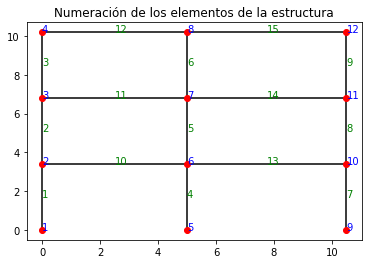

In [ ]:
# Dibujo de la estructura.
plt.figure()
for e in range(nbar):
    plt.plot(XXNOD[LaG[e,:], X], XXNOD[LaG[e,:], Y], '-k')
    # Posición de ls etiquetas de los elementos.
    cgx = ( XXNOD[LaG[e,NL1],X] + XXNOD[LaG[e,NL2],X] )/2
    cgy = ( XXNOD[LaG[e,NL1],Y] + XXNOD[LaG[e,NL2],Y]  )/2
    # Etiquetas de los elementos.
    plt.text(cgx, cgy, str(e+1), color='g')
# Nodos.
plt.plot(XXNOD[:,X], XXNOD[:,Y], 'or') 
# Etiquetas de los nodos-
for n in range(nnds):
    plt.text(XXNOD[n,X], XXNOD[n,Y], str(n+1), color='b')              # MEJORAR UBICACIÓN.
plt.title('Numeración de los elementos de la estructura')
plt.show()

### Ensamblaje de la matriz de rigidez k para el pórtico A.



In [ ]:
# Reservo memoria para almacenar las matrices y vectores.
K_A = np.zeros((ngdl, ngdl))            # Matriz de rigidez Pórtico del eje A.
Ke  = nbar*[None]                       # Matriz de rigidez local.
T_   = nbar*[None]                       # Matriz de transformación.
idx = np.zeros((nbar, 6), dtype=int)    # Vector de índices, 6 gdl por barra.

In [ ]:
# Para cada elemento.
for e in range(nbar):

    # Coordenadas y largo del elemento:
    x1 = XXNOD[LaG[e, NL1], X]; x2 = XXNOD[LaG[e, NL2], X]
    y1 = XXNOD[LaG[e, NL1], Y]; y2 = XXNOD[LaG[e, NL2], Y]
    
    # Longitud del elemento.
    L = np.hypot(x2-x1, y2-y1)

    # Matriz de transformación de coordenadas para el elemento e.
    c = np.cos(ttheta[e]); s = np.sin(ttheta[e])    
    T_[e] = np.array([
        [ c,  s,  0,  0,  0,  0],
        [-s,  c,  0,  0,  0,  0],
        [ 0,  0,  1,  0,  0,  0],
        [ 0,  0,  0,  c,  s,  0],
        [ 0,  0,  0, -s,  c,  0],
        [ 0,  0,  0,  0,  0,  1],
    ]) 

    # Matriz de rigidez local expresada en el sistema de coordenadas locales 
    # para el elemento e.
    AE = aa[e]*E; EI = E*ii[e]; L2 = L**2; L3 = L**3
    K_loc = np.array([
        [ AE/L,    0,         0,        -AE/L,    0,         0       ],
        [  0,     12*EI/L3,   6*EI/L2,   0,     -12*EI/L3,   6*EI/L2 ],
        [  0,      6*EI/L2,   4*EI/L,    0,      -6*EI/L2,   2*EI/L  ],
        [-AE/L,    0,         0,         AE/L,    0,         0       ],
        [  0,    -12*EI/L3,  -6*EI/L2,   0,      12*EI/L3,  -6*EI/L2 ],
        [  0,      6*EI/L2,   2*EI/L,    0,      -6*EI/L2,   4*EI/L  ]
     ])
    
    # Saco sus grados de libertad.
    idx[e] = np.r_[gdl[LaG[e,NL1],:], gdl[LaG[e,NL2],:]]

    # Matriz de rigidez local en coordenadas globales.
    Ke[e] = T_[e].T @ K_loc @ T_[e]
    
    # En samblaje de Ke en K global.
    K_A[np.ix_(idx[e],idx[e])] += Ke[e]

## Condensación de la matriz de rigidez

Se llevará la matriz de rigidez $K_A$ de tamaño ```ngdl```x```ngdl```, a ser de tamaño 3x3, para que sea compatible con la matriz de masa en cálculos posteriores.

Los gdl horizontales de la columna del eje 2 y 3 se condensarán en los gdl horizontales de la columna del eje 1, para cada piso, así la correspondencia sería: 
* gdl 4: gdl 16 y 28
* gdl 7: gdl 19 y 31
* gdl 10: gdl 22 y 34

Lo mismo aplicará para los gdl de giros, y dada la numeración que se tiene, basta con sumarle 2 undiades al vector que se forme con los gdl horizontales.

In [ ]:
gdl_y = np.array([4, 16, 28, 7, 19, 31, 10, 22, 34]) -1 # primarios(JP).   
gdl_t = gdl_y + 2                                       # secundarios (JP).

Se calcula ahora la matriz condensada 

In [ ]:
K0 = SubmatricesDeK( K_A[ np.ix_( gdl_y, gdl_y ) ] )  # [Ton/m].
K1 = SubmatricesDeK( K_A[ np.ix_( gdl_y, gdl_t ) ] )  # [Ton/m].
K2 = SubmatricesDeK( K_A[ np.ix_( gdl_t, gdl_y ) ] )  # [Ton/m].
K3 = SubmatricesDeK( K_A[ np.ix_( gdl_t, gdl_t ) ] )  # [Ton/m].

In [ ]:
# Kcondensada = K0 - K1@K3^-1@K2 
#K_Acon = K0 - K1 @ np.linalg.inv(K3) @ K2
K_Acon = K0 - K1 @ np.linalg.solve(K3, K2)

### Consideración de los 4 pórticos del sistema.
La matriz calcualda anteriormente ```K_A``` corresponde a la matriz de rigidez del pórtico A, dado que tenemos 4 pórticos, los cuales en conjunto reciben las componentes por piso de la FHE, se debe tomar la rigidez de la edificación en el sentido *y* como la suma de las rigideces de los pórticos en ese sentido es decir que:

$K = 4K_A$

In [ ]:
K_con = 4*K_Acon
print(">>> K_con = 1e4*"); print(K_con/1e4)

>>> K_con = 1e4*
[[ 2.95632301 -1.67074179  0.34665001]
 [-1.67074179  2.33592802 -1.08990012]
 [ 0.34665001 -1.08990012  0.80153734]]


## Cálculo de los desplazamientos y Verificación de Derivas.

Siendo la ecuación $F = KU$, se despeja U el vector de desplazamiento para calcularse como $U = inv(K)F$.

In [ ]:
# Renombro el vector de fuerzas como F para fácil entendimiento.
F = ffhhee  

# Resulevo el sistema despejando U.
U = np.linalg.solve(K_con, F) * 100    # [cm]. 

In [ ]:
# Añado los desplazamiento del suelo (nulos) al vector de desplazamientos.
U_modificado = np.append(U[::-1], 0)

# Calculo los desplazamientos relativos como la diferencia entre el  
# desplazamiento del piso inferior y superior.
delta = np.flip( abs( np.diff( U_modificado ) ) )   

# Verificación de las derivas.
verificacion = np.zeros(NPISOS, dtype=np.dtype('U100'))
for i in range(NPISOS):
    if delta[i] < DELTA_MAX:
        verificacion[i] = "Si"
    else:
        verificacion[i] = "No"

tabla_derivas = pd.DataFrame(
    data = np.c_[np.round(U, 3), np.round(delta, 3), verificacion],
    index = np.arange(NPISOS)+1,
    columns = ["U [cm]", "U relativo [cm]", "¿Cumple?"]
)
tabla_derivas.index.name = "Piso"
print(tabla_derivas)

     U [cm] U relativo [cm] ¿Cumple?
Piso                                
1     2.352           2.352       Si
2     5.375           3.023       Si
3     7.112           1.736       Si


## Solución del determinante $|K - w_i^2M|=0$

Considerando que el vector de fuerzas (FHE) contiene las fuerzas horizontales que se aplicarán en la estructura, contando de abajo hacia arriba, y que en ese orden se obtienen los desplazamientos, la matriz de masa se organizará siguiendo dicho orden, es decir:

 ```
 PISOS = [1, 2, 3] = [losa, losa, cubierta]
 
 F = [f1,
      f2,
      f3]

 U = [u1,
      u2,
      u3]

 M = [m1,  0,  0
       0, m2,  0
       0,  0, m3] 
  ```

In [ ]:
# Matriz de masa.
M = np.diag([D_LOSA, D_LOSA, D_CUB])*A_LOSA/g   # [tnf.s^2/m]
print(">>> M = "); 
print(M.round(1))

>>> M = 
[[9.  0.  0. ]
 [0.  9.  0. ]
 [0.  0.  4.5]]


In [ ]:
# Variables simbólicas.
lam, ome, fi, alf = sp.symbols('lambda, omega, Phi, alpha')

# Polinomio caracterísitco.
poli_car = sp.det( sp.Matrix(K_con - lam*M) )

# Solución de los lambdas, lams = wi^2
lams = np.sort(np.array([ float( sp.re( sp.solve( poli_car, lam )[0]) ),
                          float( sp.re( sp.solve( poli_car, lam )[1]) ),
                          float( sp.re( sp.solve( poli_car, lam )[2]) )]
                        ))

In [ ]:
print(">>> Polinomio característico:\n"); print(sp.pretty(poli_car))

>>> Polinomio característico:

                    3                     2                                   
- 363.386456982817⋅λ  + 2786916.42385257⋅λ  - 4487391333.80739⋅λ + 76782442168

     
3.733


### Cálculo de vibraciones, frecuencias y periodos.

In [ ]:
wwi = lams**0.5      # [rad/s]   Vector de frecuencias angulares.       
Tt  = 2*np.pi/wwi    # [s]       Vector de periodos de la estructura.
ff  = 1/Tt           # [Hz]      Vector de frecuencias.

In [ ]:
print(f">>> {sp.pretty(lam)}: Soluciones {sp.pretty(lam)} del polinomio.")
print(f">>> {sp.pretty(ome)}: Frecuencias angulares {sp.pretty(ome)} de la edificación.")
print(">>> T: Periodos T de la edificación.")
print(">>> f: Frecuencias f de la edificación.\n")

tabla_vfp = pd.DataFrame(
    data = np.c_[lams.round(2), wwi.round(2), Tt.round(3), ff.round(3)],
    index = np.arange(NPISOS)+1,
    columns = [f"{sp.pretty(lam)}", f"{sp.pretty(ome)} [rad/s]", "T [s]", "f [Hz]"]
)
print(tabla_vfp)

>>> λ: Soluciones λ del polinomio.
>>> ω: Frecuencias angulares ω de la edificación.
>>> T: Periodos T de la edificación.
>>> f: Frecuencias f de la edificación.

         λ  ω [rad/s]  T [s]  f [Hz]
1   193.86      13.92  0.451   2.216
2  1985.32      44.56  0.141   7.091
3  5490.11      74.10  0.085  11.793


### Cálculo del Periodo $T$ de Rayleigh

Según Título A, capítulo 2, A.4.2.1. de la NSR-10, el periodo de Rayleigh o periodo fundamental se calcula mediante la siguiente fórmula:

$ T_1 = 2\pi \sqrt{ \frac{\sum_{i=1}^{n}(w_i\delta_i)}{g\sum_{i=1}^{n}(f_i\delta_i)}}$


In [ ]:
# Periodo de Rayleigh (fundamental), A.4.2.1. de la NSR-10.
T_rayleigh = 2*np.pi*np.sqrt( np.sum(M*g * (U/100)**2) / ( g*np.sum(F*(U/100))) ) 

print(">>> Periodo de Rayleigh:   T_rayleigh = ", np.round(T_rayleigh, 3), "s.") 
print(">>> T. fundamental Aprox.: Ta =         ", np.round(T_a, 3), "s.")

>>> Periodo de Rayleigh:   T_rayleigh =  0.451 s.
>>> T. fundamental Aprox.: Ta =          0.38 s.


### Matriz Modal $\Phi$ y comprobaciones.

La matriz modal $\Phi$ de la estructura se obtiene como aquella conformada por los vectores columna propios del determinante $|K_{con} -w_i^2M|$

In [ ]:
# Reservo memoria para matrices y vectores.
Phi = np.zeros((NPISOS, NPISOS))    # Matriz modal.
rr  = np.zeros(NPISOS)              # Vector de parámetros de normalización.

for j in range(NPISOS):
    # Modo de vibración j sin normaliar. 
    phi_j = np.linalg.eigh( K_con - wwi[j]**2 * M )[1][:, j]
    # Parámetro para normalizar respecto a la masa.
    r_j = phi_j.T @ M @ phi_j
    # Añado el modo de vibración como columna en la matriz Phi.
    Phi[:, j] += phi_j / np.sqrt(r_j)

In [ ]:
print(f">>> Matriz modal de la estructura:\n{sp.pretty(fi)}=\n")
print(Phi)

>>> Matriz modal de la estructura:
Φ=

[[ 0.10166634  0.23293734  0.21593666]
 [ 0.23271943  0.09967925 -0.21709492]
 [ 0.30571265 -0.30668789  0.18689915]]


Para comprobar los cálculos realizados se deben satisfacer las siguientes operaciones entre matrices:

1. $\Phi^TM\Phi = I$
2. $\Phi^TK\Phi = w_i^2$

In [ ]:
prob1 = Phi.T @ M @ Phi         # Compronación de identidad.
prob2 = Phi.T @ K_con @ Phi     # Compronación ecuación de frecuencia.

print(f">>> {sp.pretty(fi)}T.M.{sp.pretty(fi)} = ")
print(np.round(prob1, 3))
print()
print(f">>> {sp.pretty(fi)}T.K_con.{sp.pretty(fi)} = ")
print(np.round(prob2, 3))

>>> ΦT.M.Φ = 
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0. -0.  1.]]

>>> ΦT.K_con.Φ = 
[[ 193.857    0.      -0.   ]
 [   0.    1985.325   -0.   ]
 [  -0.      -0.    5490.109]]


### Cálculo de la participación de masa modal

* La participación modal se calcula como $\alpha = \Phi^TM$,
* La masa modal efectiva como $\alpha^2$,
* El porcentaje de masa como $\%M = \frac{\alpha_j^2}{\sum_{i=1}^{n}\alpha_i^2}$. 

In [ ]:
alfa = Phi.T @ M @ np.ones((NPISOS, 1))       # Cálculo de la participación modal
part_masa = alfa**2 / np.sum(alfa**2)    
por_part_masa = part_masa*100             # Porcentaje de participación.

print(">>> Vector de participación de masa modal de la estructura:")
print(f">>> {sp.pretty(alf)}=")
print(alfa)

print("\n>>> Vector de % de participación de masa modal de la estructura:")
print(">>> %M=")
print(np.round(por_part_masa, 2))

print("\n>>> Verificación de que la suma de  % de participación sea del 100%:")
if np.isclose(np.sum(por_part_masa), 100):
    print(">>> Cumple")
else:
    print(">>> No cumple") 

>>> Vector de participación de masa modal de la estructura:
>>> α=
[[4.38070872]
 [1.61180911]
 [0.82977511]]

>>> Vector de % de participación de masa modal de la estructura:
>>> %M=
[[85.38]
 [11.56]
 [ 3.06]]

>>> Verificación de que la suma de  % de participación sea del 100%:
>>> Cumple


## Ecuaciones desacopladas.

Suponiendo que hay un desplazamiento unitario en cada uno de los pisos ($U_0=[1, 1, 1]^T$), pero con una velocidad inical no nula.

Conociendo que la ecuación diferencial desacoplada que representa el movimiento en el tiempo es: $\eta (t) = Asin(wt) + Bcos(wt)$.

In [ ]:
# Consideración para el caso 2D trabajado y facilidad de lectura.
NMODOS = NPISOS 
NUs = NMODOS

In [ ]:
# Vector de desplazamientos iniciales unitarios.
U_0 = np.ones(NMODOS)

# Vector B.
B = Phi.T @ M @ U_0

# Vector de tiempos en los cuales se realizará el cálculo de las ecuaciones 
# desacopladas.
tt = np.linspace(0, 10, 1000)
instantes = len(tt)

# Reservo memoria para almacenar los resultados.
#     U3  U2  U1
#     -----------
# w1 |
# w2 |
# w3 |
w_para_u = np.zeros((NMODOS, NMODOS, instantes))

# Cálculo de las ecuaciones desacopladas
for i in range(NMODOS):
    for j in range(NUs):
        wi_para_uj = Phi[i][j] * B[i] * np.cos(wwi[i]**0.5*tt)
        w_para_u[i][j] += wi_para_uj

La acción completa de los modos de vibración será $U_t = \sum_{i=1}^{n} \Phi^i\eta(t)$

In [ ]:
# Acción completa de cada modo de vibración.
# [Ut3, UT2, UT1] 

U_t = np.zeros((NUs, instantes))

for j in range(NUs):
    for i in range(NMODOS):
        U_t[j] += w_para_u[i, j]


Desplazamientos desacoplados en función de (w, t):



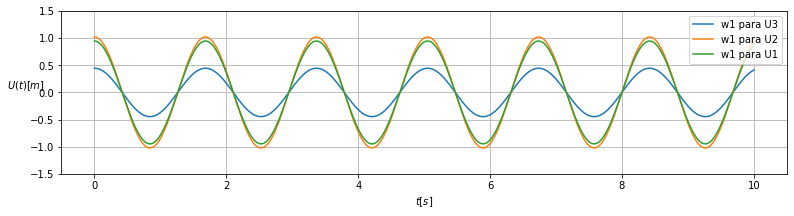

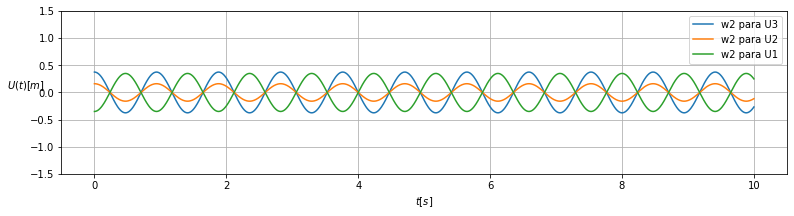

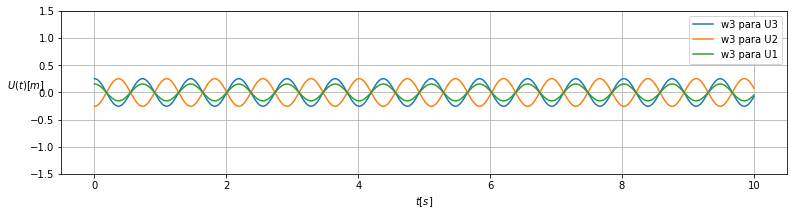



Desplazamientos acoplados en función de (w, t):



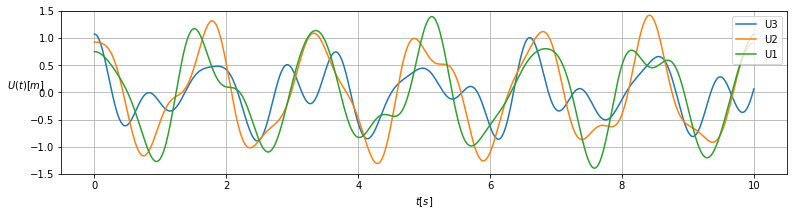

In [ ]:
# Baúl de etiquetas para cada gráfica.
BAUL = [
        ["w1 para U3", "w1 para U2", "w1 para U1"],
        ["w2 para U3", "w2 para U2", "w2 para U1"],
        ["w3 para U3", "w3 para U2", "w3 para U1"],
        ["U3", "U2", "U1"]
        ]

# Gráficos de las variaciones.

print("\nDesplazamientos desacoplados en función de (w, t):\n")
for i in range(NMODOS + 1):
    fig = plt.figure()
    fig.set_size_inches(13,3)
    ax = fig.add_subplot(111)
    ax.grid(b=True, which='major', linestyle='-')
    ax.set_ylabel(r'$U(t)[m]$', rotation=0)
    ax.set_xlabel(r'$t[s]$')
    ax.set_ylim(-1.5, 1.5)    
    if i > 2:
        print("\nDesplazamientos acoplados en función de (w, t):\n")
        for j in range(NUs):
            ax.plot(tt, U_t[j], '-', label=BAUL[i][j] )
            ax.legend(loc=1)
    else: 
        for j in range(NUs):
            ax.plot(tt, w_para_u[i][j], '-',label=BAUL[i][j] )       
            ax.legend(loc=1)
    plt.show()
    print()


Modos de vibración de la estructura:



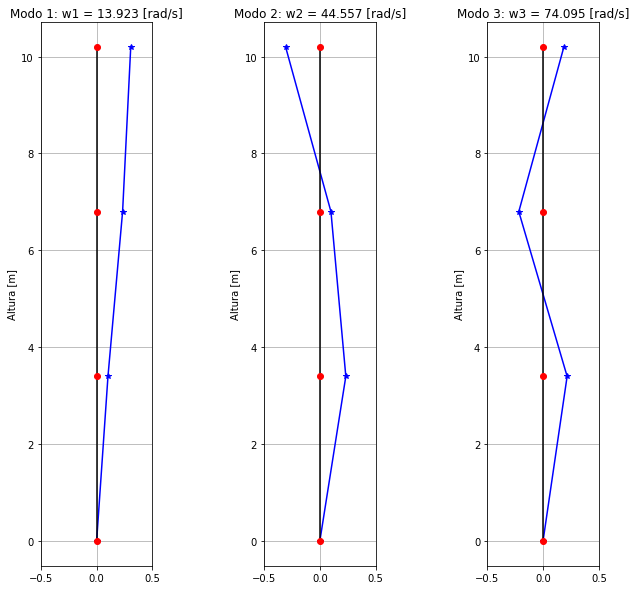

In [ ]:
# Organizo los arreglos para graficar.
grf_pisos = np.zeros(NPISOS+1); grf_pisos[1:]+=hh_piso
grf_Phi = np.zeros((NPISOS+1, NMODOS)); grf_Phi[1:, :] += Phi

# Gráfico de los modos de vibración.
print("\nModos de vibración de la estructura:\n")
fig = plt.figure()
fig.set_size_inches(10, 10)
plt.subplots_adjust(wspace=1, hspace=0.5)
for i in range(NMODOS):
    ax = fig.add_subplot(1, 3, i+1)
    ax.grid(b=True, which='major', linestyle='-')
    ax.set_ylabel("Altura [m]")
    # Gráfico de los modos.
    ax.plot(grf_Phi[:,i], grf_pisos, '*-b')      
    # Gráfico de referencia sistema simplificado.
    ax.plot(np.zeros(NPISOS+1), grf_pisos, '-k')
    ax.plot(np.zeros(NPISOS+1), grf_pisos, 'or')
    ax.set_title(f"Modo {i+1}: w{i+1} = {wwi[i].round(3)} [rad/s]")
    # Ajusto los límites del eje x.
    ax.set_xlim([-0.5, 0.5])

plt.show()